In [ ]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')


In [ ]:
!pip install -q  -U transformers datasets accelerate peft trl bitsandbytes wandb #bitsandbytes is for quantization because we are not going to use the model in full precision
#wandb for reporting to have a nice dashboard to track the process of our model
#peft is the fine tuning process
 #trl is a wrapper is for supervised fine tuning or reinforcment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Pipeline
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer

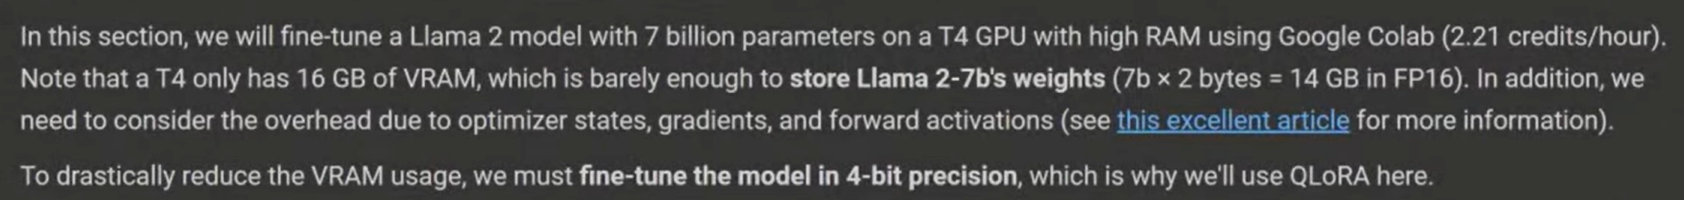

In [ ]:
# Model
base_model = "NousResearch/Llama-2-7b-hf"
new_model = "llama-2-7b-miniplatypus"

# Dataset
dataset=load_dataset("nilamasrouri98/finetune",split="train")#thats why we had it in the form of DatasetDict that can include multiple Dataset object

#tokenize
tokenizer=AutoTokenizer.from_pretrained(base_model,use_fast=True)#using the fast version of it
# we are going to add padding token because we have dataset with different number of tokens so they have the same lenght
#we can have differn ttype of padding: right ,left, both padding
tokenizer.pad_token=tokenizer.eos_token #end of sentence token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

now we are setting up the configuration for QLoRa and its quantization

In [ ]:
#quantization conguration:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
# LoRA configuration
peft_config=LoraConfig(
    lora_alpha=32,#alpha is the strength of the adapter
    lora_dropout= 0.5,
    r=16, #size of the matrix !
    bias="none",
    task_type="causal_LM",#bcause it is autoregressive!!!!!!!!!!
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj'] #which modules you want to train
)
# Load base moodel
model=AutoModelForCausalLM.from_pretrained(
  base_model,
  quantization_config=bnb_config,
  device_map={"":0},
 )

model=prepare_model_for_kbit_training(model)


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

RuntimeError: No GPU found. A GPU is needed for quantization.

![](https://i.imgur.com/bBf6ARw.png)

See Hugging Face's [Llama implementation](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L229C4-L229C4) for more information about target modules.